# Testing Snowplow Algorithm

In [1]:
%load_ext autoreload
%autoreload 2

Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

Now reload all other modules for updated depot

In [2]:
import Snowplow_Routing_Middleton.dual_graphs as dual_graphs
import Snowplow_Routing_Middleton.construction as construction
import Snowplow_Routing_Middleton.plotting as plotting
import Snowplow_Routing_Middleton.local_search as local_search
import Snowplow_Routing_Middleton.initialize as initialize
import Snowplow_Routing_Middleton.params as params

from Snowplow_Routing_Middleton.shortest_paths import ShortestPaths
from Snowplow_Routing_Middleton.crossover import apply_crossover
from Snowplow_Routing_Middleton.genetic import run_genetic
from Snowplow_Routing_Middleton.solution import Solution
from Snowplow_Routing_Middleton.costs import routes_cost, route_travel_time
from Snowplow_Routing_Middleton.routes_representations import create_full_routes_with_returns
from Snowplow_Routing_Middleton.turns import turn_direction_count

import folium
import osmnx as ox
import networkx as nx
import datetime
import shapely
import numpy as np
import matplotlib.pyplot as plt


In [3]:
approach = "genetic"
instance = "smallstreets"

G = initialize.create_small_streets()
DEPOT = params.find_depot(G)[0]
if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, DEPOT)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



Adding depot source 13


In [4]:
print(G)
print(G_DUAL)

MultiDiGraph with 51 nodes and 139 edges
MultiDiGraph with 140 nodes and 463 edges


In [5]:
sp = ShortestPaths(G_DUAL, False, False)

In [6]:
r, rreq = construction.route_generation(G, sp, DEPOT)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, DEPOT), 0)
print("Old cost:", S_first.cost)

Deadheading time hours: 0.2326138928204739
Old cost: 4509.496057477062


{'sharp right': 21, 'right': 16, 'left': 13, 'straight': 86, 'u-turn': 13, 'sharp left': 18}


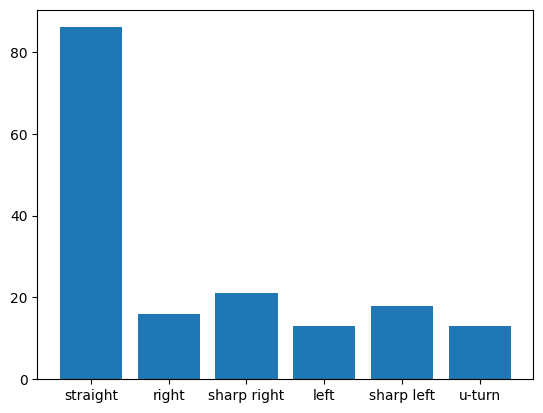

In [7]:
full_routes = create_full_routes_with_returns(G, sp, rreq, DEPOT)
counts, x_axis, y_axis = turn_direction_count(G_DUAL, full_routes)
print(counts)
plt.bar(x_axis, y_axis)
plotting.plot_moving_routes_folium(G, full_routes, label_color="green", path_color="green", m=None)

In [18]:
def find_clusters_of_edges(G: nx.MultiDiGraph) -> tuple[dict[tuple[tuple[int, int, int], list[tuple[int,int,int]]]], dict[tuple[tuple[int, int, int], tuple[int,int,int]]]]:
    """
    Find pairs of edges in a graph that represent the same road segment in opposite directions, and find 
    pairs of edges that represent the same road segment in the same direction.

    Args:
        G (nx.MultiDiGraph): The graph representing the road network.
    Returns:
        tuple[dict[tuple[tuple[int, int, int], list[tuple[int,int,int]]]], dict[tuple[tuple[int, int, int], tuple[int,int,int]]]]
        A tuple of two dictionaries mapping edges in a pair (or more) or an antipair to each other. 
        The first dictionary contains pairs of edges that represent the same road segment in the same direction, 
        and the second dictionary contains pairs of edges that represent the same road segment in opposite directions
    """
    lstrings = dict() # dictionary mapping linestrings to edges
    pairs_dict = dict() # dict mapping edge to its pair. Each edge is marked both as a key and a value
    antipairs_dict = dict()
    for edge in G.edges(data=True, keys=True):
        edge_tup = (edge[0], edge[1], edge[2])
        if edge[3]['geometry'] is not None:
            lstring = tuple(edge[3]['geometry'].coords)
            # matching pair or more, allow for multiple edges to be on the same road
            if lstring in lstrings.keys():
                current_edges = pairs_dict.get(edge_tup, [])
                # update the current edges to include the new edge
                pairs_dict.update({edge_tup: [lstrings[lstring], *current_edges]})
                for e in current_edges:
                    new_edges = [edge_tup, *[edge for edge in current_edges if edge != e], lstrings[lstring]]
                    print(new_edges)
                    pairs_dict.update({e, new_edges})
                
                # update the new edge to include the current edges
                pairs_dict.update({lstrings[lstring]: [edge_tup, *current_edges]})
                # lstrings.pop(lstring)

            # matching antipair (same road, opposite direction)
            if lstring[::-1] in lstrings.keys():
                antipairs_dict.update({edge_tup: lstrings[lstring[::-1]]})
                antipairs_dict.update({lstrings[lstring[::-1]]: edge_tup})
            
            lstrings.update({lstring: edge_tup})

    return pairs_dict, antipairs_dict
def lengthen_lstring_coords(lstring: shapely.LineString, diff: float) -> list[tuple[float, float]]:
    """
    Get the coordinates of a LineString with additional points added to make the lines smoother.

    Helper function for plot_moving_routes_folium.

    Args:
        lstring (shapely.LineString): The LineString to get coordinates from.
        diff (float): The maximum difference between two points in the LineString.
    Returns:
        list[tuple[float, float]]: A list of coordinates for the LineString.
    """
    lat_long_coords = [(y, x) for x, y in lstring.coords]
    lstring_lengthed_coords = list()
    for i in range(len(lat_long_coords)):
        lat,long=lat_long_coords[i]
        if i < len(lat_long_coords) - 1:
            next_lat, next_long = lat_long_coords[i + 1]
            dif_lat, dif_long = next_lat - lat, next_long - long

            if dif_lat > diff or dif_long > diff:
                num_intervals = int(max(abs(dif_lat), abs(dif_long)) // diff)
                new_lat_coords = np.linspace(lat, next_lat, num_intervals)
                new_long_coords = np.linspace(long, next_long, num_intervals)

                lstring_lengthed_coords.extend([(new_long_coords[i], new_lat_coords[i]) for i in range(num_intervals)])
            else:
                lstring_lengthed_coords.append((long, lat))
        else:
            lstring_lengthed_coords.append((long, lat))
    return lstring_lengthed_coords, lat_long_coords

def plot_moving_routes_folium(G: nx.MultiDiGraph, full_route: list[tuple[int, int, int]], m: folium.Map | None, label_color: str, path_color: str, dif=1e-4) -> folium.Map:
    """
    Plots moving routes on an animated Folium map.

    Args:
        G (nx.MultiDiGraph): The graph containing the route data.
        full_route (list[tuple[int, int, int]]): A list of tuples representing the edges in the route.
        m (folium.Map | None): An existing Folium map to plot on, or None to create a new map.
        label_color (str): The color of the labels for the markers.
        path_color (str): The color of the path lines.
    Returns:
        folium.Map: The Folium map with the plotted routes.
    """
    G_copy = G.copy()
    if m is None:
        m = folium.Map(location=[43.1, -89.5], zoom_start=12)
    count = 0
    current_time = datetime.datetime.now()
    features = list()

    pairs_dict, antipairs_dict = find_clusters_of_edges(G)
    mapped_edges, partially_mapped_antipairs = set(), set()
    for edge in full_route:
        edge_data = G_copy.get_edge_data(edge[0], edge[1], edge[2])   
        if edge_data is None:
            continue
        
        graph_attributes = {"color": path_color, "dashed": edge_data['reversed'], "weight": 5}
        # if the edge is a part of a pair
        if edge in pairs_dict.keys():
            # if the first part of the edge hasn't been serviced, make the line thinner
            num_mapped_edges = len([edge for pair_edge in pairs_dict[edge] if pair_edge in mapped_edges])+1
            total_edges = len(pairs_dict[edge])+1
            graph_attributes['weight']= num_mapped_edges/total_edges * 5
        # if edge in antipairs_dict.keys():
        #     # if the first part of the edge hasn't been serviced, make the line dashed
        #     if edge not in partially_mapped_antipairs and antipairs_dict[edge] not in partially_mapped_antipairs:
        #         graph_attributes['dashed'] = True
        #         partially_mapped_antipairs.add(edge)

            
        deadhead = False if edge not in mapped_edges else True
        mapped_edges.add(edge)

        name = edge_data.get("name", "Unnamed")
        if deadhead:
            graph_attributes['color'] = "red"

        lstring = edge_data['geometry']
        coords, lat_long_coords = lengthen_lstring_coords(lstring, dif)
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "LineString",
                "coordinates": coords
            },
            "properties": {
                "times": [str(current_time + datetime.timedelta(minutes=i)) for i in range(len(coords))],
                "name": name,
                "edge": edge,
                "order": count,
                "style": {
                    "color": graph_attributes["color"],
                    "weight": graph_attributes['weight'],
                    "dashArray": "5, 10" if graph_attributes['dashed'] else None
                },
            }
        }
        features.append(feature)
        folium.PolyLine(locations=lat_long_coords, color="black", weight=.5, tooltip=edge).add_to(m)
        current_time += datetime.timedelta(minutes=len(coords))
    folium.plugins.TimestampedGeoJson(
        {
            "type": "FeatureCollection",
            "features": features,
        },
        period="PT5M",
        add_last_point=False,
    ).add_to(m)
    folium.plugins.TimestampedGeoJson(
        {
            "type": "FeatureCollection",
            "features": features,
        },
        period="PT5M",
        add_last_point=True,
        duration="PT1M"
    ).add_to(m)
    return m
plot_moving_routes_folium(G, full_routes, None, "green", "green", 1e-4)

In [9]:
route_travel_time(G, full_routes, DEPOT)

3738.813783188002

Test Local Search

In [10]:
required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, DEPOT), 0)
print("Old cost:", S_first.cost)

Deadheading time hours: 0.2326138928204739
Old cost: 4509.496057477062


In [11]:
S_new = local_search.local_improve(S_first, G, sp, required_edges, DEPOT, threshold=1)
print("New cost", S_new.cost)

New cost 4395.349269225451


In [12]:
s1, s1req = construction.route_generation(G, sp, DEPOT)
S1 = Solution(s1req, dict(), routes_cost(G, sp, s1req, DEPOT), 0)
S1 = local_search.local_improve(S1, G, sp, required_edges, DEPOT, threshold=1)

s2, s2req = construction.route_generation(G, sp, DEPOT)
S2 = Solution(s2req, dict(), routes_cost(G, sp, s2req, DEPOT), 0)
S2 = local_search.local_improve(S2, G, sp, required_edges, DEPOT, threshold=1)

Deadheading time hours: 0.2960248653545115
Deadheading time hours: 0.2556613722451791


In [13]:
routes_new = apply_crossover(G, sp, S1.routes, S2.routes, DEPOT)
routes_cost(G, sp, routes_new, DEPOT)

Deadheading time hours: 0.24454482696055044


4512.691408964317

In [14]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp, DEPOT)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")

initial generation 0
Deadheading time hours: 0.21651439400717992
initial generation 1
Deadheading time hours: 0.23368390531116462
initial generation 2
Deadheading time hours: 0.21651439400717992
initial generation 3
Deadheading time hours: 0.21234772734051324
initial generation 4
Deadheading time hours: 0.21651439400717992
initial generation 5
Deadheading time hours: 0.1921676217706774
initial generation 6
Deadheading time hours: 0.21066673185415355
initial generation 7
Deadheading time hours: 0.1777758882444705
initial generation 8
Deadheading time hours: 0.20789553213776996
initial generation 9
Deadheading time hours: 0.20619881878466123
Iteration 0
Deadheading time hours: 0.20789553213776996
Iteration 1
Deadheading time hours: 0.20789553213776996
Iteration 2
Deadheading time hours: 0.2661027129970066
Iteration 3
Deadheading time hours: 0.180933106340788
Iteration 4
Deadheading time hours: 0.22468931157946684
Iteration 5
Deadheading time hours: 0.22415850241408355
Iteration 6
Deadhea

In [15]:
full_optimized_route = create_full_routes_with_returns(G, sp, sol.routes, DEPOT)
print("Travel time optimized", route_travel_time(G, full_optimized_route, DEPOT))
print("Travel time original", route_travel_time(G, full_routes, DEPOT))
print("Cost optimiazed:", routes_cost(G, sp, sol.routes, DEPOT))
print("Costs origianl:", routes_cost(G, sp, rreq, DEPOT))

Travel time optimized 3674.827684730268
Travel time original 3738.813783188002
Deadheading time hours: 0.20789553213776996
Cost optimiazed: 4334.5575421657395
Deadheading time hours: 0.2326138928204739
Costs origianl: 4509.496057477062


## Plot the routes using Folium

## Algorithm to draw linestrings

1. Have a fixed difference between lat long coords to accept
2. Loop through the coords of the linestring.
    - If the difference is smaller than the desired, continue
    - Otherwise use Numpy to artificially add coords the linestring
3. Add each individual time to individual coords on the linestring so that it is a smooth animation


The reason some of the antipairs are still dashed is because of the construction of the graph. Randomly selected 10% of edges to be not serviced, so some of the corresponding edges in a couple antipairs aren't ever serviced.

In [16]:
original_full_route = create_full_routes_with_returns(G, sp, rreq, DEPOT)
plotting.plot_moving_routes_folium(G, original_full_route, label_color="green", path_color="green", m=None)

In [17]:
new_full_route = create_full_routes_with_returns(G, sp, sol.routes, DEPOT)
plotting.plot_moving_routes_folium(G, new_full_route, label_color="blue", path_color="blue", m=None)

Heuristics to implement:
- Go straight as long as possible if its unserviced
- If we hit an unserviced edge at an intersection, we should do everything we can to turn onto that road to service it
- Basically completely prohibit u-turns

Cost function adjustments:
- Rewarding straights and penalizing u-turns
- Penalizing any deadheading (we want to avoid as much as possible!)
